In [1]:
# initiating gpu using tensorflow.
import tensorflow as tf
from tensorflow.compat.v1.keras.backend import set_session
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
config.log_device_placement = True
sess = tf.compat.v1.Session(config=config)
set_session(sess)

2022-10-22 16:13:30.632887: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-22 16:13:30.802766: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-10-22 16:13:31.798005: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-10-22 16:13:31.798115: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or 

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla K80, pci bus id: 0001:00:00.0, compute capability: 3.7



2022-10-22 16:13:34.401494: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 11553 MB memory:  -> device: 0, name: Tesla K80, pci bus id: 0001:00:00.0, compute capability: 3.7


In [2]:
import numpy as np
import pandas as pd
import glob
import random 
import os
import cv2
from shutil import copy,copytree
import shutil


from patchify import patchify

#from google.colab import files
import os
#import zipfile

#visulaziation
import matplotlib.pyplot as plt
#from google.colab.patches import cv2_imshow


# image
from PIL import Image

# sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
#tensorflow
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img,img_to_array
from tensorflow.keras.applications import VGG16, InceptionV3, ResNet101V2, Xception, ResNet50V2, VGG19
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import Adam
#from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import load_model
from tensorflow.keras import models, layers
from keras.utils.vis_utils import plot_model
from tensorflow.keras.layers import Dense,Conv2D,MaxPool2D,Flatten,Dropout,BatchNormalization,Activation,GlobalAveragePooling2D

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix

#setting seed to reproduce the same result every time the code is re-run
random_state = 17
tf.random.set_seed(random_state)
np.random.seed(random_state)



In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
df=pd.read_csv('./Concat_Split_Images/files_and_targets.csv')

In [5]:
df.head()

,Unnamed: 0,files,target
0,0,./Concat_Split_Images/Controls/C01_image__00.npy,Controls
1,1,./Concat_Split_Images/Controls/C01_image__01.npy,Controls
2,2,./Concat_Split_Images/Controls/C01_image__02.npy,Controls
3,3,./Concat_Split_Images/Controls/C01_image__10.npy,Controls
4,4,./Concat_Split_Images/Controls/C01_image__11.npy,Controls


**Label encoding the traget variable:**

In [6]:
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
#num_classes = 2
df['category'] = labelencoder.fit_transform(df['target'])
df

,Unnamed: 0,files,target,category
0,0,./Concat_Split_Images/Controls/C01_image__00.npy,Controls,0
1,1,./Concat_Split_Images/Controls/C01_image__01.npy,Controls,0
2,2,./Concat_Split_Images/Controls/C01_image__02.npy,Controls,0
3,3,./Concat_Split_Images/Controls/C01_image__10.npy,Controls,0
4,4,./Concat_Split_Images/Controls/C01_image__11.npy,Controls,0
...,...,...,...,...
323,323,./Concat_Split_Images/Patients/P02_image__83.npy,Patients,1
324,324,./Concat_Split_Images/Patients/P02_image__84.npy,Patients,1
325,325,./Concat_Split_Images/Patients/P02_image__85.npy,Patients,1
326,326,./Concat_Split_Images/Patients/P02_image__86.npy,Patients,1


**Creating a column image and Stroing the files names as numpy array:**

In [7]:
df['image']=df['files'].map(lambda x: np.load(x))

##**Feature and Target Split**

In [8]:
features=df['image']
target=df['category']

**Training, Validation and Test Split**

We first split the dataset to 80% training data and 20% testing data. We then take the 80% training data and split it into 87.5% training data and 12.5% validation data, to form our 70% Training - 10% Validation - 20% Testing. Note that the split will be applied across each class individually to ensure there is enough samples from each class in each split for accurate modeling, meaning each class will be split 70:10:20 as well. This is done by setting 'stratify' in train_test_split function to our target.

Training: 80% 87.5% = 70% Validation: 80% 12.5% = 10% Testing: 20%

In [37]:
X_train,X_test,y_train,y_test_r=train_test_split(features,target,train_size=0.9,stratify=target, random_state=random_state)

In [38]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, train_size=0.9, stratify=y_train, random_state=random_state)

**Target One-Hot Encoding**

Creating one-hot vectors of size (1,2) for each label



In [39]:
from keras.utils.np_utils import to_categorical
num_classes = 2
y_train = to_categorical(y_train, num_classes = 2)
y_test = to_categorical(y_test_r, num_classes = 2)
y_val = to_categorical(y_val, num_classes = 2)

**Converting numarry into tensor**

In [12]:
X_train_normal = np.asarray(X_train.tolist())
X_test_normal = np.asarray(X_test.tolist())
X_val_normal=np.asarray(X_val.tolist())

In [13]:
input_shape=(512,512,10)
X_train_normal=X_train_normal.reshape(X_train_normal.shape[0],*(input_shape))
X_test_normal=X_test_normal.reshape(X_test_normal.shape[0],*(input_shape))
X_val_normal=X_val_normal.reshape(X_val_normal.shape[0],*(input_shape))

In [14]:
X_train_normal[0].shape

(512, 512, 10)

#**Building the model**
**Transfer Learning Using ResNet101V2**

In [15]:
from tensorflow.keras.applications.vgg16 import VGG16
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dropout
from keras.backend import dropout
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten

In [16]:
#Import vgg model  
vgg_model = VGG16(include_top=False, weights='imagenet',classes=2)
print(vgg_model.summary())

2022-10-22 16:14:07.714412: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 11553 MB memory:  -> device: 0, name: Tesla K80, pci bus id: 0001:00:00.0, compute capability: 3.7


Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [17]:
#Get the dictionary of config for vgg16
vgg_config = vgg_model.get_config()

In [18]:
# Change the input shape to new desired shape
h, w, c = 512, 512, 10
vgg_config["layers"][0]["config"]["batch_input_shape"] = (None, h, w, c)

In [19]:
#Create new model with the updated configuration
vgg_updated = Model.from_config(vgg_config)
print(vgg_updated.summary())

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 512, 512, 10)]    0         
                                                                 
 block1_conv1 (Conv2D)       (None, 512, 512, 64)      5824      
                                                                 
 block1_conv2 (Conv2D)       (None, 512, 512, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 256, 256, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 256, 256, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 256, 256, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 128, 128, 128)     0     

In [20]:
# Check Weights of first conv layer in the original model...
orig_model_conv1_block1_wts = vgg_model.layers[1].get_weights()[0]

In [21]:
# Check Weights of first conv layer in the new model...
new_model_conv1_block1_wts = vgg_updated.layers[1].get_weights()[0]
print(new_model_conv1_block1_wts[:,:,0,0])
print(new_model_conv1_block1_wts[:,:,1,0])
print(new_model_conv1_block1_wts[:,:,2,0])
print(new_model_conv1_block1_wts[:,:,3,0])
print(new_model_conv1_block1_wts[:,:,4,0])

[[-0.06815252  0.02318217  0.07346698]
 [-0.04329469  0.00610515  0.04075771]
 [-0.05001664  0.01586339  0.06408326]]
[[ 0.02576429  0.04703876 -0.04945927]
 [ 0.00574466  0.04461532  0.08503712]
 [ 0.03286838 -0.02842337 -0.00056198]]
[[-0.03551443 -0.05402194 -0.09000695]
 [ 0.04510195 -0.06815399 -0.01361101]
 [ 0.08246516  0.09247202 -0.05630611]]
[[ 0.05924895  0.03225272 -0.05356552]
 [-0.05036833 -0.07272834  0.01255088]
 [ 0.07077288 -0.04729345 -0.02909327]]
[[-0.04406929  0.04821246 -0.01903702]
 [-0.07126343  0.05197429  0.0790196 ]
 [ 0.07766052  0.0549734   0.07770554]]


In [22]:
# Function that calculates average of weights along the channel axis and then
#copies it over n number of times. n being the new channels that need to be concatenated with the original channels. 
def avg_and_copy_wts(weights, num_channels_to_fill):  #num_channels_to_fill are the extra channels for which we need to fill weights
  average_weights = np.mean(weights, axis=-2).reshape(weights[:,:,-1:,:].shape)  #Find mean along the channel axis (second to last axis)
  wts_copied_to_mult_channels = np.tile(average_weights, (num_channels_to_fill, 1)) #Repeat (copy) the array multiple times
  return(wts_copied_to_mult_channels)

In [23]:
#Get the configuration for the updated model and extract layer names. 
 
vgg_updated_config = vgg_updated.get_config()
vgg_updated_layer_names = [vgg_updated_config['layers'][x]['name'] for x in range(len(vgg_updated_config['layers']))]

In [24]:
first_conv_name = vgg_updated_layer_names[1]

In [25]:
#Update weights for all layers. And for the first conv layer, copy the first
#three layer weights and fill others with the average of all three. 
for layer in vgg_model.layers:
    if layer.name in vgg_updated_layer_names:
     
      if layer.get_weights() != []:  #All convolutional layers and layers with weights (no input layer or any pool layers)
        target_layer = vgg_updated.get_layer(layer.name)
    
        if layer.name in first_conv_name:    #For the first convolutionl layer
          weights = layer.get_weights()[0]
          biases  = layer.get_weights()[1]
    
          weights_extra_channels = np.concatenate((weights,   #Keep the first 3 channel weights as-is and copy the weights for additional channels.
                                                  avg_and_copy_wts(weights, c - 3)),  # - 3 as we already have weights for the 3 existing channels in our model. 
                                                  axis=-2)
                                                  
          target_layer.set_weights([weights_extra_channels, biases])  #Now set weights for the first conv. layer
          target_layer.trainable = False   #You can make this trainable if you want. 
    
        else:
          target_layer.set_weights(layer.get_weights())   #Set weights to all other layers. 
          target_layer.trainable = False  #You can make this trainable if you want.

In [26]:
# Check Weights of first conv layer in the new model...
#Compare against the original model weights
new_model_conv1_block1_wts_updated = vgg_updated.layers[1].get_weights()[0]
print(new_model_conv1_block1_wts_updated[:,:,0,0])
print(new_model_conv1_block1_wts_updated[:,:,1,0])
print(new_model_conv1_block1_wts_updated[:,:,2,0])
print(new_model_conv1_block1_wts_updated[:,:,5,0])
print(new_model_conv1_block1_wts_updated[:,:,8,0])

[[ 0.42947057  0.373467   -0.06136011]
 [ 0.27476987  0.03868078 -0.36722335]
 [-0.05746817 -0.26224968 -0.35009676]]
[[ 0.55037946  0.44007453 -0.08138704]
 [ 0.34573907  0.04063221 -0.4535013 ]
 [-0.05863491 -0.33066967 -0.4850302 ]]
[[ 0.4800154   0.4085474  -0.06514555]
 [ 0.31047726  0.05020237 -0.40338343]
 [-0.05087169 -0.2852275  -0.41851634]]
[[ 0.48662183  0.40736297 -0.06929757]
 [ 0.31032872  0.04317178 -0.40803602]
 [-0.05565825 -0.29271564 -0.4178811 ]]
[[ 0.48662183  0.40736297 -0.06929757]
 [ 0.31032872  0.04317178 -0.40803602]
 [-0.05565825 -0.29271564 -0.4178811 ]]


In [27]:
#instantiate a base model with pre-trained weights.
base_model=vgg_updated

In [28]:
#freeze the base model
base_model.trainable = False

In [29]:
#Create new model on top
model=Sequential()
model.add(base_model)
model.add(Dense(2048))
model.add(Activation('relu'))
model.add(Dense(1024))
model.add(Activation('relu'))
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

In [30]:
optim=Adam(learning_rate=0.001)
model.compile(loss='binary_crossentropy',metrics=['accuracy'],optimizer=optim)
print("Model compilation completed.")

Model compilation completed.


In [31]:
callbacks = [EarlyStopping(monitor='val_accuracy',patience=200)]

In [32]:
history = model.fit(X_train_normal,y_train,batch_size=2,
                                       epochs=200,
                                       validation_data=(X_val_normal,y_val),callbacks=callbacks)

Epoch 1/200


2022-10-22 16:14:11.867215: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8201
2022-10-22 16:14:12.132804: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


133/133 [==============================] - 48s 309ms/step - loss: 1.4816 - accuracy: 0.8415 - val_loss: 3.4624e-05 - val_accuracy: 1.0000
Epoch 2/200
133/133 [==============================] - 39s 291ms/step - loss: 0.0319 - accuracy: 0.9849 - val_loss: 9.3061e-06 - val_accuracy: 1.0000
Epoch 3/200
133/133 [==============================] - 39s 291ms/step - loss: 0.0458 - accuracy: 0.9887 - val_loss: 1.4616e-12 - val_accuracy: 1.0000
Epoch 4/200
133/133 [==============================] - 39s 291ms/step - loss: 0.3190 - accuracy: 0.9774 - val_loss: 1.5882e-10 - val_accuracy: 1.0000
Epoch 5/200
133/133 [==============================] - 39s 292ms/step - loss: 0.2122 - accuracy: 0.9660 - val_loss: 5.2655e-11 - val_accuracy: 1.0000
Epoch 6/200
133/133 [==============================] - 39s 292ms/step - loss: 0.0205 - accuracy: 0.9887 - val_loss: 3.1868e-12 - val_accuracy: 1.0000
Epoch 7/200
133/133 [==============================] - 39s 292ms/step - loss: 0.0177 - accuracy: 0.9925 - val_lo

Epoch 56/200
133/133 [==============================] - 40s 301ms/step - loss: 0.0107 - accuracy: 0.9962 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 57/200
133/133 [==============================] - 40s 301ms/step - loss: 0.0100 - accuracy: 0.9962 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 58/200
133/133 [==============================] - 40s 301ms/step - loss: 0.0212 - accuracy: 0.9962 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 59/200
133/133 [==============================] - 40s 301ms/step - loss: 0.0174 - accuracy: 0.9887 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 60/200
133/133 [==============================] - 40s 300ms/step - loss: 0.0091 - accuracy: 0.9962 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 61/200
133/133 [==============================] - 40s 301ms/step - loss: 0.0058 - accuracy: 0.9962 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 62/200
133/133 [==============================] - 40s 301ms/step - loss: 0.0390 - accura

133/133 [==============================] - 40s 301ms/step - loss: 1.2021 - accuracy: 0.9887 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 165/200
133/133 [==============================] - 40s 301ms/step - loss: 0.7344 - accuracy: 0.9849 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 166/200
133/133 [==============================] - 40s 300ms/step - loss: 0.1080 - accuracy: 0.9925 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 167/200
133/133 [==============================] - 40s 300ms/step - loss: 0.0095 - accuracy: 0.9962 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 168/200
133/133 [==============================] - 40s 301ms/step - loss: 0.0089 - accuracy: 0.9962 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 169/200
133/133 [==============================] - 40s 301ms/step - loss: 0.0542 - accuracy: 0.9925 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 170/200
133/133 [==============================] - 40s 301ms/step - loss: 0.2222 - accuracy: 0.9

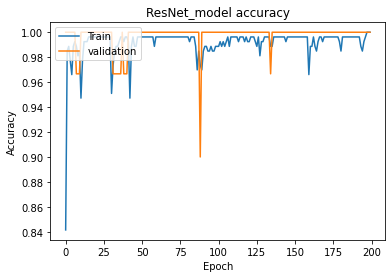

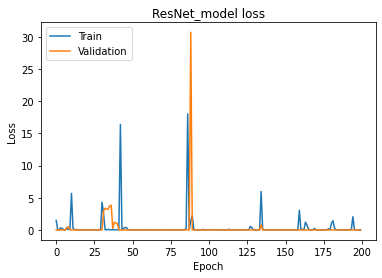

In [33]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('ResNet_model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('ResNet_model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

##**Predictions**

In [34]:
# Generate generalization metrics
score = model.evaluate(X_test_normal,y_test,verbose=0)
print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')

2022-10-22 18:27:20.309144: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.83GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2022-10-22 18:27:20.433120: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.02GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2022-10-22 18:27:20.433170: W tensorflow/core/kernels/gpu_utils.cc:50] Failed to allocate memory for convolution redzone checking; skipping this check. This is benign and only means that we won't check cudnn for out-of-bounds reads and writes. This message will only be printed once.


Test loss: 0.0 / Test accuracy: 1.0


In [35]:
score

[0.0, 1.0]

In [40]:
protein_name= 'All_Channels'
dataset_name= 'nDNAPatients'

In [41]:
from sklearn.metrics import confusion_matrix, classification_report
# Predict the label of the test_images
pred = model.predict(X_test_normal)
pred = np.argmax(pred,axis=1)

confusion_mat = confusion_matrix(y_test_r, pred)

print(classification_report(y_test_r, pred))

2/2 [==============================] - 2s 137ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        23
           1       1.00      1.00      1.00        10

    accuracy                           1.00        33
   macro avg       1.00      1.00      1.00        33
weighted avg       1.00      1.00      1.00        33



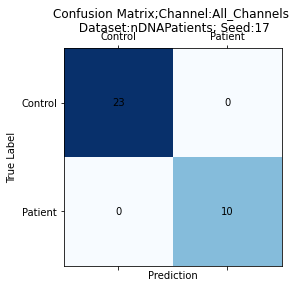

<Figure size 1080x720 with 0 Axes>

In [42]:
fig, ax = plt.subplots()

ax.matshow(confusion_mat, cmap=plt.cm.Blues)

ax.set_title(f"Confusion Matrix;Channel:{protein_name} \n Dataset:{dataset_name}; Seed:{random_state}")
ax.set_xlabel('Prediction')
ax.set_ylabel('True Label')

tick_labels = ['Control', 'Patient']

ax.set_xticks(range(len(tick_labels)))
ax.set_yticks(range(len(tick_labels)))
ax.set_xticklabels(tick_labels)
ax.set_yticklabels(tick_labels)

for i in range(len(tick_labels)):
    for j in range(len(tick_labels)):
        ax.text(j, i, confusion_mat[i, j],
               ha='center', va='center')
        
plt.figure(figsize=(15,10))
plt.show()

**Saving the model**

The saved full model file includes:

The model's architecture,The model's weight values

In [43]:
model.save(f'./models/multichannel/Vgg16{random_state}.h5')
print("saved the model")

saved the model
